In [1]:
from __future__ import print_function
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import datasets
from sklearn import model_selection
from sklearn.linear_model import Lasso
from sklearn import metrics
from IPython.display import display, HTML
import scipy.stats as stats
import pylab
import warnings
import statsmodels.api as sm
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegressionCV
from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, KFold
import shap

warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Utill function

In [2]:

def apply_model_and_print_result(model, X_train, X_test, y_train, y_test, name):
    trained_model, y_pred = model(X_train, X_test, y_train, y_test)
    matrix = print_result_matrix(name, X_test, y_test, y_pred)

    return trained_model, y_pred, matrix
    
def print_result_matrix(model_name, X_test, true, prediction):
    matrix = {}
    matrix['mse'] = mean_squared_error(true, prediction)
    matrix['mae'] = mean_absolute_error(true, prediction)
    matrix['rmse'] = np.sqrt(matrix['mae'])
    matrix['r2'] = r2_score(true, prediction)

    

    # Adjusted R-squared 계산
    n = X_test.shape[0]  # 샘플의 개수
    p = X_test.shape[1]  # 특성의 개수
    adjusted_r2 = 1 - (1 - matrix['r2']) * (n - 1) / (n - p - 1)
    matrix['adjusted r2'] = adjusted_r2

    print(f"### {model_name} ###")
    print(f"mae: {matrix['mae']}")
    print(f"mse: {matrix['mse']}")
    print(f"rmse: {matrix['rmse']}")
    print(f"r2: {matrix['r2']}")
    print(f"adjusted r2: {matrix['adjusted r2']}")

    return matrix
    

def compare_true_and_pred(y_pred, y_true):
    # 실제 값과 예측값의 산점도 그리기
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.title('prediction')
    plt.xlabel('actual value')
    plt.ylabel('predicted value')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--') # 대각선
    plt.show()

def apply_deep_shap(model, X, X_train, X_test):
    feature_names = X.columns.tolist()
    # Create the SHAP DeepExplainer
    explainer = shap.DeepExplainer(model, X_train[:1000])  # Using a subset of X_train as the background dataset

    # Compute SHAP values
    shap_values = explainer.shap_values(X_test)

    # Plot the SHAP values
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)


def apply_shap(model, X_columns, X_test):
    feature_names = X_columns


    # SHAP Explainer 객체 생성
    explainer = shap.Explainer(model)

    # 테스트 데이터에 대한 SHAP 값 계산
    shap_values = explainer(X_test)

    # SHAP 요약 플롯 생성
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)


# 모델링

## Neural Network Based

### Fully-Connected - baseline and application

In [3]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers.legacy import Adam  # 변경된 부분
from keras.layers import Input, Dense, BatchNormalization, Add, Activation
from keras.models import Model
from keras.regularizers import l1_l2


from sklearn.metrics import r2_score


def train_FC_1(X_train, X_test, y_train, y_test):
    # 모델 정의 및 컴파일
    model = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='relu',), # 입력 레이어 및 첫 번째 은닉 레이어
        Dense(128, activation='relu'), # 두 번째 은닉 레이어
        Dense(64, activation='relu'), # 두 번째 은닉 레이어
        Dense(1, activation='linear')  # 출력 레이어
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') # 모델 컴파일
    # 모델 훈련
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

    # 테스트 데이터에 대한 예측
    y_pred = model.predict(X_test)

    return model, y_pred


def train_FC_2(X_train, X_test, y_train, y_test):
    # 모델 정의 및 컴파일
    model = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='relu'),  # 입력 레이어 및 첫 번째 은닉 레이어
        BatchNormalization(),  # 배치 정규화 추가

        Dense(128, activation='relu'),  # 두 번째 은닉 레이어
        BatchNormalization(),  # 배치 정규화 추가

        Dense(64, activation='relu'),  # 세 번째 은닉 레이어
        BatchNormalization(),  # 배치 정규화 추가
        
        Dense(1, activation='linear')   # 출력 레이어
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # 모델 컴파일

    # 모델 훈련
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

    # 테스트 데이터에 대한 예측
    y_pred = model.predict(X_test)

    return model, y_pred

def train_FC_3(X_train, X_test, y_train, y_test):
    # 모델 정의 및 컴파일
    # 입력 레이어
    input_layer = Input(shape=(X_train.shape[1],))

    # 첫 번째 Dense 레이어 블록 및 배치 정규화
    a = Dense(128, activation='relu')(input_layer)
    b = Dense(128, activation='relu')(a)
    BatchNormalization(),  # 배치 정규화 추가

    b = Add()([a, b])  # 스킵 커넥션 추가

    # 두 번째 Dense 레이어 블록 및 배치 정규화
    c = Dense(128, activation='relu')(b)
    d = Dense(128, activation='relu')(c)
    BatchNormalization(),  # 배치 정규화 추가
    d = Add()([c, d])  # 스킵 커넥션 추가

    # 세 번째 Dense 레이어 블록 및 배치 정규화
    e = Dense(128, activation='relu')(d)
    f = Dense(128, activation='relu')(e)
    BatchNormalization(),  # 배치 정규화 추가
    f = Add()([e, f])  # 스킵 커넥션 추가

    # 네 번째 Dense 레이어 블록 및 배치 정규화
    g = Dense(64, activation='relu')(f)
    h = Dense(64, activation='relu')(g)
    BatchNormalization(),  # 배치 정규화 추가
    h = Add()([g, h])  # 스킵 커넥션 추가


    # 출력 레이어
    output_layer = Dense(1, activation='linear')(h)

    model = Model(inputs=input_layer, outputs=output_layer)
    # Nadam 옵티마이저 인스턴스 생성
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.001)

    # 모델 생성 및 컴파일
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # 수정된 부분


    # 모델 훈련
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

    # 테스트 데이터에 대한 예측
    y_pred = model.predict(X_test)

    return model, y_pred


### Fully-Connected - NAS

In [4]:
import keras_tuner as kt

import shutil

def train_FC_with_nas(X_train, X_test, y_train, y_test):
    def model_builder(hp):
        model = Sequential()
        model.add(Dense(hp.Int('units_input', min_value=32, max_value=512, step=32),
                        activation='relu', input_shape=(X_train.shape[1],)))
        model.add(BatchNormalization())

        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(Dense(hp.Int(f'units_layer_{i}', min_value=16, max_value=256, step=16),
                            activation='relu'))
            if hp.Boolean(f'batch_norm_layer_{i}'):
                model.add(BatchNormalization())
            if hp.Boolean(f'dropout_layer_{i}'):
                model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])),
                      loss='mean_squared_error')

        return model

    tuner = kt.Hyperband(
        model_builder,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        hyperband_iterations=2,
        directory='my_dir',
        project_name='fc_with_nas'
    )

    tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=2)
    best_model = tuner.get_best_models(num_models=1)[0]

# 디렉토리 삭제
    shutil.rmtree('my_dir/fc_with_nas')
    y_pred = best_model.predict(X_test)
    return best_model, y_pred


### TabNet

In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor

def train_tabnet(X_train, X_test, y_train, y_test):
    # TabNet 모델 생성
    tabnet_reg = TabNetRegressor()
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)
    # 모델 훈련
    tabnet_reg.fit(
      X_train, y_train,
      eval_set=[(X_test, y_test)],
      patience=50, max_epochs=1000,
      eval_metric=['mse']
    )

    # 테스트 데이터로 예측
    y_pred = tabnet_reg.predict(X_test)

    return tabnet_reg, y_pred

## Tree based

### Decision Tree

In [6]:
from sklearn.model_selection import GridSearchCV

def train_decision_tree(X_train, X_test, y_train, y_test):
    # 모델 초기화
    tree_model = DecisionTreeRegressor(random_state=42)

    # 그리드 서치를 위한 하이퍼파라미터 설정
    parameters = {
        'max_depth': [10, 20, 30],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1, 2, 4]
    }

    # GridSearchCV 초기화
    # cross validation 3

    grid_search = GridSearchCV(estimator=tree_model, param_grid=parameters, cv=3, n_jobs=-1, verbose=2)

    # 훈련 데이터로 그리드 서치 실행
    grid_search.fit(X_train, y_train)

    # 최적의 파라미터와 모델 출력
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return best_model, y_pred

### XGBoost

In [7]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def train_xgboost_with_grid_search(X_train, X_test, y_train, y_test):
    # 모델 초기화


    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    # Grid Search를 위한 하이퍼파라미터 설정
    parameters = {
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.01, 0.05, 0.1], 
        'n_estimators': [100, 500, 1000]
    }

    # GridSearchCV 초기화
    # cross validation 3
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=2)

    # 훈련 데이터로 Grid Search 실행
    grid_search.fit(X_train, y_train)

    # 최적의 파라미터와 모델 출력
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    return best_model, y_pred

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def train_random_forest_with_grid_search(X_train, X_test, y_train, y_test):
    # 랜덤 포레스트 모델 초기화
    rf = RandomForestRegressor(random_state=42)
    # Grid Search를 위한 하이퍼파라미터 설정
    param_grid = {
        'n_estimators': [100, 500, 100], 
        'max_depth': [10, 15, 20], 
        'min_samples_split': [2, 5, 10]
    }

    # GridSearchCV 초기화
    # cross validation 3

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # 훈련 데이터로 Grid Search 실행
    grid_search.fit(X_train, y_train)

    # 최적의 파라미터와 모델 출력
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    return best_model, y_pred


### Cat Boost

In [9]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

def train_catboost_with_grid_search(X_train, X_test, y_train, y_test):
    # CatBoost 모델 초기화
    catboost_model = CatBoostRegressor(random_seed=42, silent=True)

    # Grid Search를 위한 하이퍼파라미터 설정
    param_grid = {
        'depth': [8, 10, 12],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [500, 750, 1000]
    }

    # GridSearchCV 초기화
    # cross validation 3
    grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # 훈련 데이터로 Grid Search 실행
    grid_search.fit(X_train, y_train)

    # 최적의 파라미터와 모델 출력
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    return best_model, y_pred

### Light GBM

In [10]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

def train_lightgbm_with_grid_search(X_train, X_test, y_train, y_test):
    # LightGBM 모델 초기화
    lgbm_model = LGBMRegressor(random_state=42)

    # Grid Search를 위한 하이퍼파라미터 설정
    param_grid = {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000]
    }

    # GridSearchCV 초기화
    # cross validation 3

    grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    # 훈련 데이터로 Grid Search 실행
    grid_search.fit(X_train, y_train)

    # 최적의 파라미터와 모델 출력
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    return best_model, y_pred

# 데이터 로딩

In [11]:
def load_and_prepare_data(file_path):
	data = pd.read_csv(file_path)
	data = data.drop(columns=['stay_id'])

	data = data[data['within_time_range'] == 0].drop(columns="within_time_range")
	
	X = data.drop(columns=['los'])
	y = data['los']

	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)

	X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)	
	dataset = [X_train, X_test, y_train, y_test, X.columns]

	return dataset


In [12]:
path_0_12_6 = 'data/merged_data_0_12_6.csv'
data = pd.read_csv(path_0_12_6)
data

gender  anchor_age  admission_type_AMBULATORY OBSERVATION  \
0          1          48                                  False   
1          1          48                                  False   
2          1          48                                  False   
3          1          43                                  False   
4          1          43                                  False   
...      ...         ...                                    ...   
2030       0          57                                  False   
2031       0          57                                  False   
2032       1          67                                  False   
2033       1          67                                  False   
2034       1          67                                  False   

      admission_type_DIRECT EMER.  admission_type_DIRECT OBSERVATION  \
0                           False                              False   
1                           False                              False   
2                           False                              False   
3                           False                              False   
4                           False                              False   
...                           ...                                ...   
2030                        False                              False   
2031                        False                              False   
2032                        False                              False   
2033                        False                              False   
2034                        False                              False   

      admission_type_ELECTIVE  admission_type_EU OBSERVATION  \
0                       False                          False   
1                       False                          False   
2                       False                          False   
3                       False                          False   
4                       False                          False   
...                       ...                            ...   
2030                    False                          False   
2031                    False                          False   
2032                    False                          False   
2033                    False                          False   
2034                    False                          False   

      admission_type_EW EMER.  admission_type_OBSERVATION ADMIT  \
0                       False                             False   
1                       False                             False   
2                       False                             False   
3                        True                             False   
4                        True                             False   
...                       ...                               ...   
2030                     True                             False   
2031                     True                             False   
2032                    False                              True   
2033                    False                              True   
2034                    False                              True   

      admission_type_SURGICAL SAME DAY ADMISSION  ...  blood_pressure_4_avg  \
0                                          False  ...             75.666667   
1                                          False  ...             75.666667   
2                                          False  ...             75.666667   
3                                          False  ...             73.333333   
4                                          False  ...             73.333333   
...                                          ...  ...                   ...   
2030                                       False  ...             79.000000   
2031                                       False  ...             79.000000   
2032                                       False  .

# 1단계 학습(0hr ~ 6hr)

## 0hr ~ 6hr 데이터 로드

In [13]:
path_0_6_3 = 'data/merged_data_0_6_3.csv'
dataset_0_6_3 = load_and_prepare_data(path_0_6_3)

0
(1943, 63) (486, 63) (1943,) (486,)


In [14]:
X_train, X_test, y_train, y_test = dataset_0_6_3[0:4]
X_columns = dataset_0_6_3[-1]
dataset_0_6_3 = dataset_0_6_3[0:4]

In [15]:
X_train

array([[ 0.75104563,  0.14801177,  0.        , ..., -0.11427589,
        -0.64493029, -0.55876791],
       [ 0.75104563,  0.84340941,  0.        , ..., -0.31133055,
         0.15851569, -0.54413046],
       [ 0.75104563, -2.19105304,  0.        , ..., -0.32430542,
        -0.48424109,  1.13669072],
       ...,
       [ 0.75104563, -0.23129604,  0.        , ...,  0.19235493,
        -0.1628627 ,  0.52039813],
       [-1.33147702,  0.71697348,  0.        , ...,  0.28877907,
        -0.40389649, -0.72972571],
       [ 0.75104563, -0.16807807,  0.        , ..., -0.04447394,
         1.63149998, -0.04566415]])

In [16]:
result = {}
matrix = {}

## Neural Network Based

### Fully-Connected - baseline and application

In [17]:
# fully-connected baseline
fc_1_model, fc_1_pred, fc_1_matrix = apply_model_and_print_result(train_FC_1, *dataset_0_6_3, 'fc_1')
result['fc1'] = {'adjusted r2': fc_1_matrix['adjusted r2'], 'model': fc_1_model}
matrix['fc1'] = fc_1_matrix


Epoch 1/100
49/49 [==============================] - 0s 2ms/step - loss: 175.7352 - val_loss: 164.4596
Epoch 2/100
49/49 [==============================] - 0s 1ms/step - loss: 123.9102 - val_loss: 138.3405
Epoch 3/100
49/49 [==============================] - 0s 1ms/step - loss: 110.4435 - val_loss: 133.2763
Epoch 4/100
49/49 [==============================] - 0s 1ms/step - loss: 101.7459 - val_loss: 121.8127
Epoch 5/100
49/49 [==============================] - 0s 1ms/step - loss: 91.0310 - val_loss: 108.0314
Epoch 6/100
49/49 [==============================] - 0s 1ms/step - loss: 75.4938 - val_loss: 99.8780
Epoch 7/100
49/49 [==============================] - 0s 1ms/step - loss: 62.4909 - val_loss: 89.6094
Epoch 8/100
49/49 [==============================] - 0s 1ms/step - loss: 53.1977 - val_loss: 77.1905
Epoch 9/100
49/49 [==============================] - 0s 1ms/step - loss: 45.0889 - val_loss: 81.0715
Epoch 10/100
49/49 [==============================] - 0s 1ms/step - loss: 35.7120 

In [18]:
# fully-connected with batch-norm
fc_2_model, fc_2_pred, fc_2_matrix  = apply_model_and_print_result(train_FC_2, *dataset_0_6_3, 'fc_2')
result['fc2'] = {'adjusted r2':fc_2_matrix['adjusted r2'], 'model': fc_2_model}
matrix['fc2'] = fc_2_matrix

Epoch 1/100
49/49 [==============================] - 0s 3ms/step - loss: 263.5620 - val_loss: 322.0117
Epoch 2/100
49/49 [==============================] - 0s 2ms/step - loss: 222.9803 - val_loss: 291.5139
Epoch 3/100
49/49 [==============================] - 0s 1ms/step - loss: 181.5829 - val_loss: 267.0461
Epoch 4/100
49/49 [==============================] - 0s 1ms/step - loss: 138.0102 - val_loss: 227.6431
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 102.8557 - val_loss: 175.1502
Epoch 6/100
49/49 [==============================] - 0s 1ms/step - loss: 69.9834 - val_loss: 134.4217
Epoch 7/100
49/49 [==============================] - 0s 1ms/step - loss: 47.6873 - val_loss: 97.3833
Epoch 8/100
49/49 [==============================] - 0s 1ms/step - loss: 33.5248 - val_loss: 76.6740
Epoch 9/100
49/49 [==============================] - 0s 1ms/step - loss: 28.9709 - val_loss: 64.2776
Epoch 10/100
49/49 [==============================] - 0s 1ms/step - loss: 20.492

In [19]:
# fully-connected with batch-norm and skip connection
fc_3_model, fc_3_pred, fc_3_matrix = apply_model_and_print_result(train_FC_3, *dataset_0_6_3, 'fc_3')
result['fc3'] = {'adjusted r2': fc_3_matrix['adjusted r2'], 'model': fc_3_model}
matrix['fc3'] = fc_3_matrix

Epoch 1/100
49/49 [==============================] - 1s 3ms/step - loss: 165.2179 - val_loss: 154.3120
Epoch 2/100
49/49 [==============================] - 0s 1ms/step - loss: 118.7864 - val_loss: 120.4581
Epoch 3/100
49/49 [==============================] - 0s 2ms/step - loss: 97.6126 - val_loss: 120.4266
Epoch 4/100
49/49 [==============================] - 0s 2ms/step - loss: 76.4903 - val_loss: 79.9862
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 51.1894 - val_loss: 80.1169
Epoch 6/100
49/49 [==============================] - 0s 2ms/step - loss: 38.2374 - val_loss: 79.0609
Epoch 7/100
49/49 [==============================] - 0s 2ms/step - loss: 34.6008 - val_loss: 45.8807
Epoch 8/100
49/49 [==============================] - 0s 2ms/step - loss: 16.3598 - val_loss: 56.9943
Epoch 9/100
49/49 [==============================] - 0s 2ms/step - loss: 13.0569 - val_loss: 35.4925
Epoch 10/100
49/49 [==============================] - 0s 2ms/step - loss: 8.4604 - val

### Fully-Connected - NAS

In [20]:
nas_model, nas_pred, nas_matrix = apply_model_and_print_result(train_FC_with_nas, *dataset_0_6_3, 'nas')
result['nas'] = {'adjusted r2': nas_matrix['adjusted r2'], 'model': nas_model}
matrix['nas'] = nas_matrix

Trial 59 Complete [00h 00m 02s]
val_loss: 99.04296875

Best val_loss So Far: 31.062461853027344
Total elapsed time: 00h 01m 00s
16/16 [==============================] - 0s 619us/step
### nas ###
mae: 3.960428635845586
mse: 37.218932385966774
rmse: 1.9900825701074782
r2: 0.8008830148505393
adjusted r2: 0.7711570194372311


### Tabnet

In [21]:
tn_model, tn_pred, tn_matrix = apply_model_and_print_result(train_tabnet, *dataset_0_6_3, 'tn')
result['tn'] = {'adjusted r2': tn_matrix['adjusted r2'], 'model': tn_model}
matrix['tn'] = tn_matrix

epoch 0  | loss: 327.83057| val_0_mse: 389.59634|  0:00:00s
epoch 1  | loss: 316.21317| val_0_mse: 386.29843|  0:00:00s
epoch 2  | loss: 310.47418| val_0_mse: 384.26289|  0:00:00s
epoch 3  | loss: 334.8616| val_0_mse: 382.48815|  0:00:00s
epoch 4  | loss: 298.19522| val_0_mse: 380.87027|  0:00:00s
epoch 5  | loss: 312.23138| val_0_mse: 379.55271|  0:00:00s
epoch 6  | loss: 308.07291| val_0_mse: 378.19701|  0:00:00s
epoch 7  | loss: 294.30127| val_0_mse: 376.38632|  0:00:00s
epoch 8  | loss: 305.52249| val_0_mse: 374.5515|  0:00:01s
epoch 9  | loss: 278.47992| val_0_mse: 372.41206|  0:00:01s
epoch 10 | loss: 283.07474| val_0_mse: 370.1264|  0:00:01s
epoch 11 | loss: 308.81061| val_0_mse: 366.89305|  0:00:01s
epoch 12 | loss: 267.77866| val_0_mse: 363.41683|  0:00:01s
epoch 13 | loss: 277.48849| val_0_mse: 359.8289|  0:00:01s
epoch 14 | loss: 240.53394| val_0_mse: 356.04732|  0:00:01s
epoch 15 | loss: 285.5701| val_0_mse: 351.14465|  0:00:01s
epoch 16 | loss: 271.77356| val_0_mse: 346.55

## Tree based

### Decision Tree

In [22]:
dt_model, dt_pred, dt_matrix = apply_model_and_print_result(train_decision_tree, *dataset_0_6_3, 'decision tree')
result['DT'] = {'adjusted r2': dt_matrix['adjusted r2'], 'model': dt_model}
matrix['DT'] = dt_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=15; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=15; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10

### XGBoost

In [23]:
xg_model, xg_pred, xg_matrix = apply_model_and_print_result(train_xgboost_with_grid_search, *dataset_0_6_3, 'XGBoost')
result['XG'] = {'adjusted r2': xg_matrix['adjusted r2'], 'model': xg_model}
matrix['XG'] = xg_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_est

### Random Forest

In [24]:
rf_model, rf_pred, rf_matrix = apply_model_and_print_result(train_random_forest_with_grid_search, *dataset_0_6_3, 'Random Forest')
result['rf'] = {'adjusted r2': rf_matrix['adjusted r2'], 'model': rf_model}
matrix['rf'] = rf_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_split=5, n_es

### Cat Boost

In [25]:
cb_model, cb_pred, cb_matrix = apply_model_and_print_result(train_catboost_with_grid_search, *dataset_0_6_3, 'Cat Boost')
result['CB'] = {'adjusted r2': cb_matrix['adjusted r2'], 'model': cb_model}
matrix['CB'] = cb_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   6.7s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   6.7s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   6.8s
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   6.9s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   6.9s
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   7.0s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   7.0s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   7.1s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   6.8s
[CV] END ........depth=8, iterations=750, learning_rate=0.01; total time=  10.2s
[CV] END ........depth=8, iterations=750, learning_rate=0.01; total time=  10.1s
[CV] END ........depth=8, iterations=750, learni


### Light GBM

In [26]:
lgb_model, lgb_pred, lgb_matrix = apply_model_and_print_result(train_lightgbm_with_grid_search, *dataset_0_6_3, 'Light GBM')
result['LGB'] = {'adjusted r2': lgb_matrix['adjusted r2'], 'model': lgb_model}
matrix['LGB'] = lgb_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3721
[LightGBM] [Info] Number of data points in the train set: 1295, number of used features: 50
[LightGBM] [Info] Start training from score 12.456978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3775
[LightGBM] [Info] Number of data points in the train set: 1295, number of used features: 49
[LightGBM] [Info] Start training from score 12.371877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006864 seconds.
You can set `force_row_

# 1차 예측 결과

In [27]:
df_matrix = pd.DataFrame(matrix)

# 데이터프레임 출력
print(df_matrix)

                   fc1        fc2        fc3        nas         tn        DT  \
mse          22.431318  21.738135  21.190813  37.218932  16.622404  3.721066   
mae           2.121857   2.402075   2.002583   3.960429   2.839786  0.449966   
rmse          1.456659   1.549863   1.415126   1.990083   1.685167  0.670795   
r2            0.879995   0.883703   0.886632   0.800883   0.911072  0.980093   
adjusted r2   0.862080   0.866342   0.869707   0.771157   0.897796  0.977121   

                   XG        rf        CB       LGB  
mse          0.440849  7.963233  1.021834  0.545551  
mae          0.072956  1.592976  0.151440  0.157332  
rmse         0.270103  1.262132  0.389153  0.396651  
r2           0.997642  0.957398  0.994533  0.997081  
adjusted r2  0.997289  0.951038  0.993717  0.996646  


In [28]:
df_matrix

fc1        fc2        fc3        nas         tn        DT  \
mse          22.431318  21.738135  21.190813  37.218932  16.622404  3.721066   
mae           2.121857   2.402075   2.002583   3.960429   2.839786  0.449966   
rmse          1.456659   1.549863   1.415126   1.990083   1.685167  0.670795   
r2            0.879995   0.883703   0.886632   0.800883   0.911072  0.980093   
adjusted r2   0.862080   0.866342   0.869707   0.771157   0.897796  0.977121   

                   XG        rf        CB       LGB  
mse          0.440849  7.963233  1.021834  0.545551  
mae          0.072956  1.592976  0.151440  0.157332  
rmse         0.270103  1.262132  0.389153  0.396651  
r2           0.997642  0.957398  0.994533  0.997081  
adjusted r2  0.997289  0.951038  0.993717  0.996646

In [29]:
best_model_name_1 = None  
best_adjusted_r2_1 = -float('inf')  
best_model_1 = None

for model_name, model_data in result.items():
    if 'adjusted r2' in model_data:
        adjusted_r2 = model_data['adjusted r2']
        if adjusted_r2 > best_adjusted_r2_1:
            best_adjusted_r2_1 = adjusted_r2
            best_model_name_1 = model_name
            best_model_1 = model_data['model']

# 가장 높은 adjusted r2 값을 가진 모델과 해당 값 출력
print("가장 높은 adjusted r2 값을 가진 모델:", best_model_name_1)
print("최고 adjusted r2 값:", best_adjusted_r2_1)

가장 높은 adjusted r2 값을 가진 모델: XG
최고 adjusted r2 값: 0.9972894113006255


### 실제값 에측값 비교

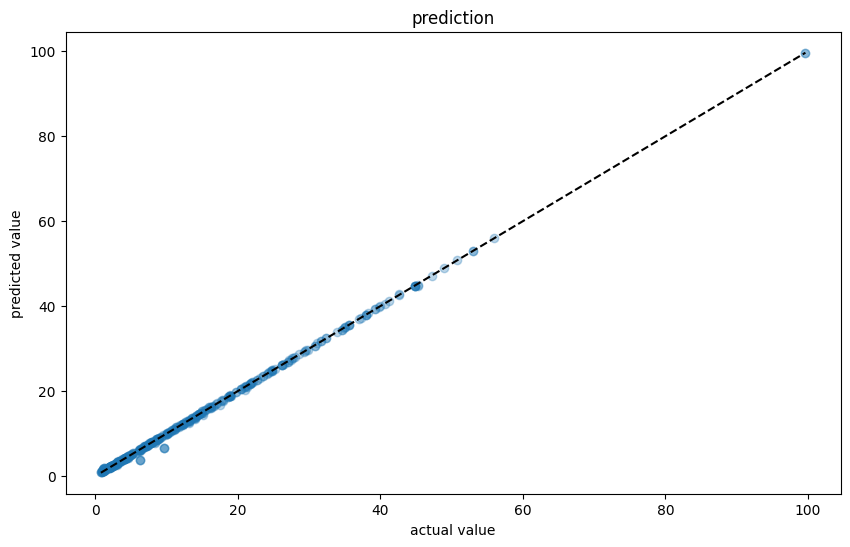

In [65]:
compare_true_and_pred(xg_pred, y_test)

### XAI - SHAP

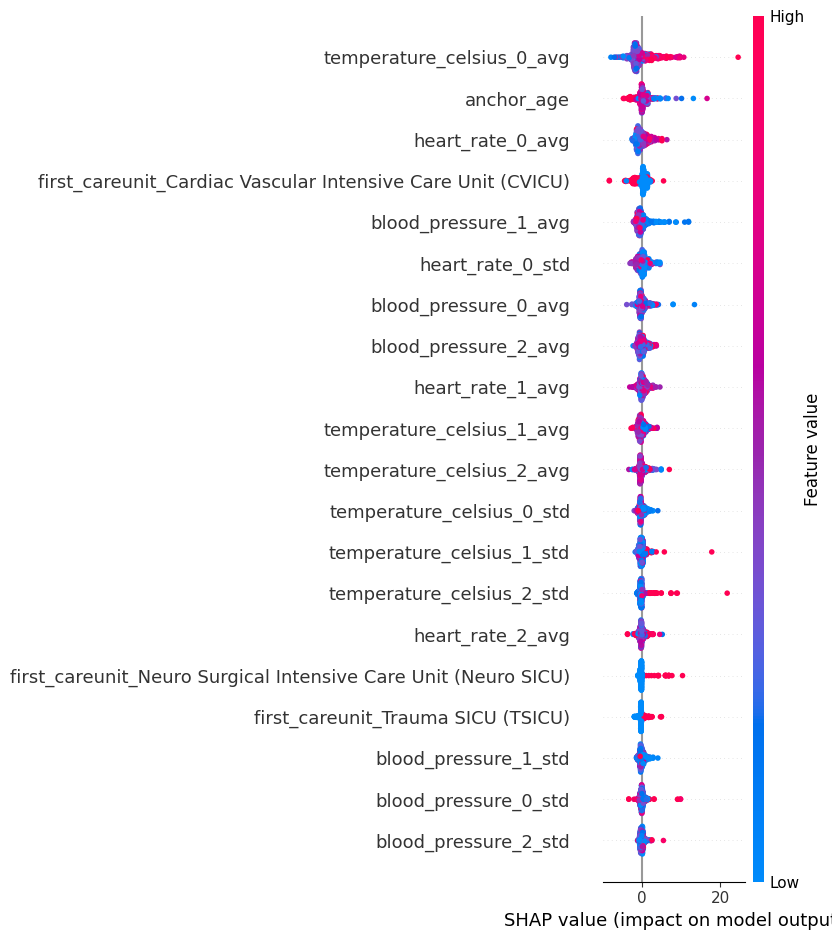

In [30]:
apply_shap(best_model_1, X_columns, X_test)

# 2단계 학습(6hr ~ 12hr)

## 데이터 로딩 및 예측 체류시간 컬럼 추가

In [31]:
dataset_0_12_6 = pd.read_csv('data/merged_data_0_12_6.csv')
dataset_0_12_6 = dataset_0_12_6.drop(columns='stay_id')

# 0시~6시의 예측을 위해 6시 이후 데이터 삭제
drop_blood_pressure_pre = ['blood_pressure_3_avg', 'blood_pressure_3_std', 'blood_pressure_4_avg', 'blood_pressure_4_std'\
						   , 'blood_pressure_5_avg', 'blood_pressure_5_std']
drop_temperature_celsius_pre = ['temperature_celsius_3_avg', 'temperature_celsius_3_std', 'temperature_celsius_4_avg', 'temperature_celsius_4_std'
								, 'temperature_celsius_5_avg', 'temperature_celsius_5_std']
drop_heart_rate_pre = ['heart_rate_3_avg', 'heart_rate_3_std', 'heart_rate_4_avg', 'heart_rate_4_std', 'heart_rate_5_avg', 'heart_rate_5_std']

dataset_0_12_6_pre = dataset_0_12_6.drop(columns=[*drop_blood_pressure_pre, *drop_temperature_celsius_pre, *drop_heart_rate_pre])

# 0~6시 데이터셋 생성
dataset_0_12_6_pre_X = dataset_0_12_6_pre.drop(columns=['los', 'within_time_range'])
dataset_0_12_6_pre_y = dataset_0_12_6_pre['los']

scaler = StandardScaler()
dataset_0_12_6_pre_X = scaler.fit_transform(dataset_0_12_6_pre_X)

expected_los = best_model_1.predict(dataset_0_12_6_pre_X)

In [34]:
# 6시 ~ 12시 데이터만 남김
drop_blood_pressure = ['blood_pressure_0_avg', 'blood_pressure_0_std', 'blood_pressure_1_avg', 'blood_pressure_1_std'\
					   , 'blood_pressure_2_avg', 'blood_pressure_2_std']
drop_temperature_celsius = ['temperature_celsius_0_avg', 'temperature_celsius_0_std', 'temperature_celsius_1_avg', 'temperature_celsius_1_std'\
							, 'temperature_celsius_2_avg', 'temperature_celsius_2_std']
drop_heart_rate = ['heart_rate_0_avg', 'heart_rate_0_std', 'heart_rate_1_avg', 'heart_rate_1_std', 'heart_rate_2_avg', 'heart_rate_2_std']

dataset_0_12_6 = dataset_0_12_6.drop(columns=[*drop_blood_pressure, *drop_temperature_celsius, *drop_heart_rate])

# 1차 예측 컬럼 생성
dataset_0_12_6['expected_los'] = expected_los

# 0~12 데이터로 0~12 안에 데이터를 예측하는 건 의미가 없다고 판단하여
# 12시간 이후에 데이터만 예측
dataset_0_12_6 = dataset_0_12_6[dataset_0_12_6['within_time_range'] == 0].drop(columns=['within_time_range'])


In [37]:
dataset_0_12_6_X = dataset_0_12_6.drop(columns=['los'])
y = dataset_0_12_6['los']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset_0_12_6_X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_columns = dataset_0_12_6_X.columns
dataset_0_12_6 = [X_train, X_test, y_train, y_test]



In [38]:
result_2 = {}
matrix_2 = {}

## Neural Network Based

### Fully-Connected - baseline and application

In [39]:
# fully-connected baseline
fc_1_model, fc_1_pred, fc_1_matrix = apply_model_and_print_result(train_FC_1, *dataset_0_12_6, 'fc_1')
result_2['fc1'] = {'adjusted r2': fc_1_matrix['adjusted r2'], 'model': fc_1_model}
matrix_2['f1'] = fc_1_matrix

Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 179.1584 - val_loss: 131.8953
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 80.5446 - val_loss: 61.2606
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 34.5988 - val_loss: 27.4744
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 19.4279 - val_loss: 25.3911
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 15.6700 - val_loss: 23.0081
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: 12.5356 - val_loss: 19.9409
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: 10.6443 - val_loss: 20.0349
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss: 9.2379 - val_loss: 17.8754
Epoch 9/100
40/40 [==============================] - 0s 1ms/step - loss: 7.1958 - val_loss: 17.9603
Epoch 10/100
40/40 [==============================] - 0s 1ms/step - loss: 6.2899 - val_loss

In [40]:
# fully-connected with batch-norm
fc_2_model, fc_2_pred, fc_2_matrix  = apply_model_and_print_result(train_FC_2, *dataset_0_12_6, 'fc_2')
result_2['fc2'] = {'adjusted r2':fc_2_matrix['adjusted r2'], 'model': fc_2_model}
matrix_2['fc2'] = fc_2_matrix

Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 237.1803 - val_loss: 322.2242
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 165.2230 - val_loss: 257.2693
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 133.3916 - val_loss: 216.9548
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 110.4856 - val_loss: 173.2462
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 90.5244 - val_loss: 139.7192
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 71.5953 - val_loss: 98.6616
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 52.2968 - val_loss: 73.6624
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 35.8461 - val_loss: 41.8445
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 24.7516 - val_loss: 31.4555
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 18.5012 

In [41]:
# fully-connected with batch-norm and skip connection
fc_3_model, fc_3_pred, fc_3_matrix = apply_model_and_print_result(train_FC_3, *dataset_0_12_6, 'fc_3')
result_2['fc3'] = {'adjusted r2': fc_3_matrix['adjusted r2'], 'model': fc_3_model}
matrix_2['fc3'] = fc_3_matrix

Epoch 1/100
40/40 [==============================] - 1s 3ms/step - loss: 131.7096 - val_loss: 62.0224
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 40.7445 - val_loss: 30.5914
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 20.2273 - val_loss: 22.3726
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 14.6382 - val_loss: 38.4778
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 10.2824 - val_loss: 18.1315
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 9.2295 - val_loss: 14.9151
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 5.3358 - val_loss: 14.5744
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 5.1170 - val_loss: 14.0239
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 4.2516 - val_loss: 14.8196
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 2.7243 - val_loss: 1

### Fully-Connected - NAS

In [42]:
nas_model, nas_pred, nas_matrix = apply_model_and_print_result(train_FC_with_nas, *dataset_0_12_6, 'nas')
result_2['nas'] = {'adjusted r2': nas_matrix['adjusted r2'], 'model': nas_model}
matrix_2['nas'] = nas_matrix

Trial 60 Complete [00h 00m 02s]
val_loss: 18.14820098876953

Best val_loss So Far: 11.511309623718262
Total elapsed time: 00h 01m 04s
13/13 [==============================] - 0s 776us/step
### nas ###
mae: 2.3756929329274357
mse: 12.773592433981811
rmse: 1.541328301474879
r2: 0.9301254662203825
adjusted r2: 0.9165740414873658


## Tree based

### Decision Tree

In [43]:
dt_model, dt_pred, dt_matrix = apply_model_and_print_result(train_decision_tree, *dataset_0_12_6, 'decision tree')
result_2['DT'] = {'adjusted r2': dt_matrix['adjusted r2'], 'model': dt_model}
matrix_2['DT'] = dt_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=15; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=15; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10

### XGBoost

In [44]:
xg_model, xg_pred, xg_matrix = apply_model_and_print_result(train_xgboost_with_grid_search, *dataset_0_12_6, 'XGBoost')
result_2['XG'] = {'adjusted r2': xg_matrix['adjusted r2'], 'model': xg_model}
matrix_2['XG'] = xg_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.4s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_est

### Random Forest

In [45]:
rf_model, rf_pred, rf_matrix = apply_model_and_print_result(train_random_forest_with_grid_search, *dataset_0_12_6, 'Random Forest')
result_2['rf'] = {'adjusted r2': rf_matrix['adjusted r2'], 'model': rf_model}
matrix_2['rf'] = rf_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_split=10, n_e

### Cat Boost

In [46]:
cb_model, cb_pred, cb_matrix = apply_model_and_print_result(train_catboost_with_grid_search, *dataset_0_12_6, 'Cat Boost')
result_2['CB'] = {'adjusted r2': cb_matrix['adjusted r2'], 'model': cb_model}
matrix_2['CB'] = cb_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   5.8s
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   5.9s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   5.9s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   6.1s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   6.2s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   5.9s
[CV] END ........depth=8, iterations=500, learning_rate=0.05; total time=   6.1s
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   6.1s
[CV] END .........depth=8, iterations=500, learning_rate=0.1; total time=   6.1s
[CV] END ........depth=8, iterations=750, learning_rate=0.01; total time=   8.7s
[CV] END ........depth=8, iterations=750, learning_rate=0.01; total time=   8.9s
[CV] END ........depth=8, iterations=750, learni

### Light GBM

In [47]:
lgb_model, lgb_pred, lgb_matrix = apply_model_and_print_result(train_lightgbm_with_grid_search, *dataset_0_12_6, 'Light GBM')
result_2['LGB'] = {'adjusted r2': lgb_matrix['adjusted r2'], 'model': lgb_model}
matrix_2['LGB'] = lgb_matrix

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2778
[LightGBM] [Info] Number of data points in the train set: 1052, number of used features: 50
[LightGBM] [Info] Start training from score 12.631424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 1053, number of used features: 50
[LightGBM] [Info] Start training from score 12.645827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

# 2차 예측 결과

In [48]:
best_model_name_2 = None  
best_adjusted_r2_2 = -float('inf')  
best_model_2 = None

for model_name, model_data in result_2.items():
    if 'adjusted r2' in model_data:
        adjusted_r2 = model_data['adjusted r2']
        if adjusted_r2 > best_adjusted_r2_2:
            best_adjusted_r2_2 = adjusted_r2
            best_model_name_2 = model_name
            best_model_2 = model_data['model']

# 가장 높은 adjusted r2 값을 가진 모델과 해당 값 출력
print("가장 높은 adjusted r2 값을 가진 모델:", best_model_name_2)
print("최고 adjusted r2 값:", best_adjusted_r2_2)

가장 높은 adjusted r2 값을 가진 모델: CB
최고 adjusted r2 값: 0.9993551553430245


In [49]:
df_matrix_2 = pd.DataFrame(matrix_2)

# 데이터프레임 출력
print(df_matrix_2)

                   f1        fc2       fc3        nas        DT        XG  \
mse          6.845995  11.273685  6.819794  12.773592  6.837787  0.138395   
mae          1.140694   1.477989  1.487961   2.375693  1.161088  0.129438   
rmse         1.068033   1.215726  1.219820   1.541328  1.077538  0.359775   
r2           0.962551   0.938330  0.962694   0.930125  0.962596  0.999243   
adjusted r2  0.955288   0.926370  0.955459   0.916574  0.955342  0.999096   

                   rf        CB       LGB  
mse          1.637109  0.098734  0.241924  
mae          0.638695  0.124956  0.074940  
rmse         0.799184  0.353492  0.273752  
r2           0.991045  0.999460  0.998677  
adjusted r2  0.989308  0.999355  0.998420  


In [50]:
df_matrix_2

f1        fc2       fc3        nas        DT        XG  \
mse          6.845995  11.273685  6.819794  12.773592  6.837787  0.138395   
mae          1.140694   1.477989  1.487961   2.375693  1.161088  0.129438   
rmse         1.068033   1.215726  1.219820   1.541328  1.077538  0.359775   
r2           0.962551   0.938330  0.962694   0.930125  0.962596  0.999243   
adjusted r2  0.955288   0.926370  0.955459   0.916574  0.955342  0.999096   

                   rf        CB       LGB  
mse          1.637109  0.098734  0.241924  
mae          0.638695  0.124956  0.074940  
rmse         0.799184  0.353492  0.273752  
r2           0.991045  0.999460  0.998677  
adjusted r2  0.989308  0.999355  0.998420

### 실제값 예측값 비교

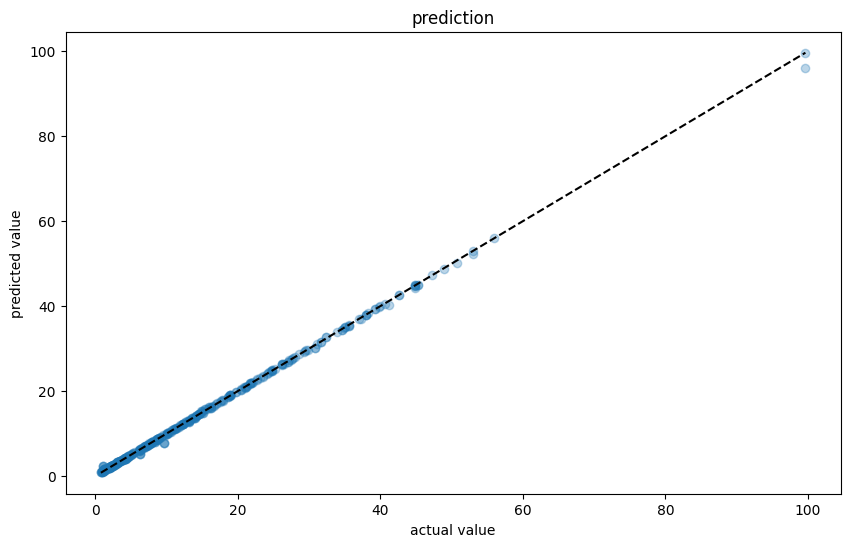

In [66]:
compare_true_and_pred(cb_pred, y_test)

### XAI - SHAP

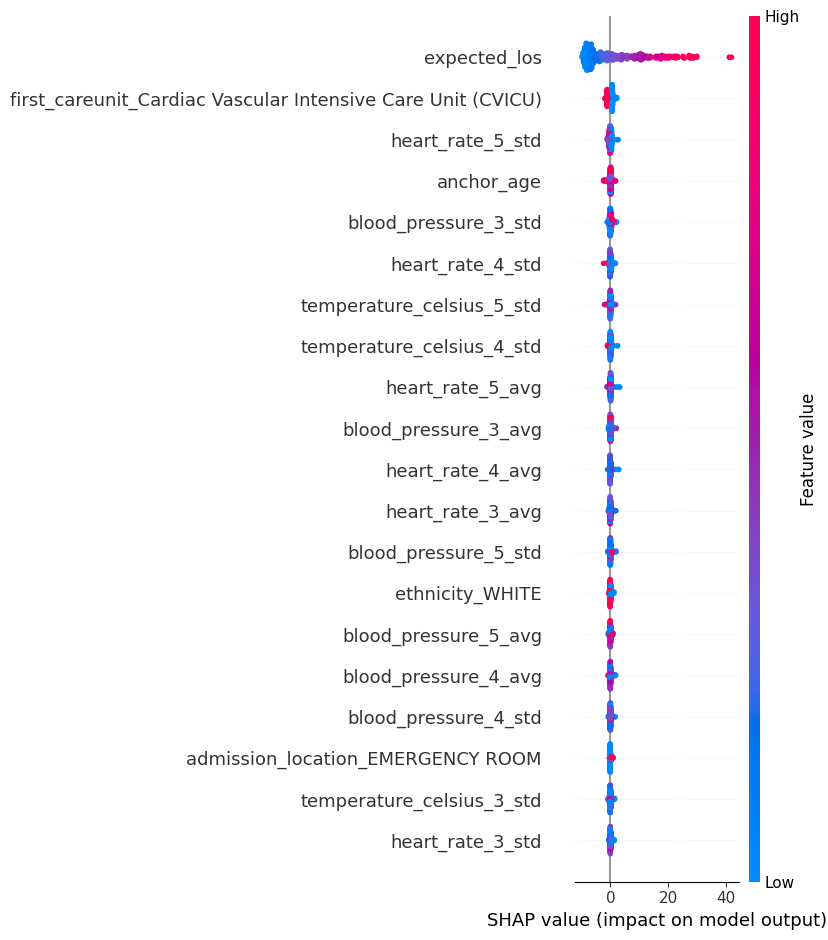

In [60]:
apply_shap(best_model_2, X_columns, X_test)